Для любой модели из курса(кроме KNN) и данных на которых она строилась: примнить метод главных компонент к данным, и сравнить работу модели на исходных данных с работой на данных где в качестве признаков используются две главные компоненты.

****

In [1]:
import numpy as np
from scipy.stats import mode
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
from my_rf_calssifier import RFClassifier
from my_metrics import metrics, get_full_report, roc_auc

In [3]:
class PCA:

    def __init__(self, k):
        self.k = k
        self.X = None
        self.W = None

    @staticmethod
    def data_scaling(X):
        X_ = X.astype(float)
        mean = np.apply_along_axis(np.mean, 0, X)
        std = np.apply_along_axis(np.std, 0, X)
        X_normed = (X - mean[np.newaxis, :]) / std[np.newaxis, :]
        return X_normed

    def fit(self, X):
        self.X = self.data_scaling(X)
        n = self.X.shape[1]
 
        covariance_matrix = self.X.T.dot(self.X)
        eig_values, eig_vectors = np.linalg.eig(covariance_matrix)
        eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        self.W = eig_pairs[0][1].reshape(n,1)
        if self.k > 1:
            for i in range(1, self.k, 1):
                self.W = np.hstack((self.W, eig_pairs[i][1].reshape(n,1)))
    
    def transform(self, X):
        Z = X.dot(self.W)
        return Z

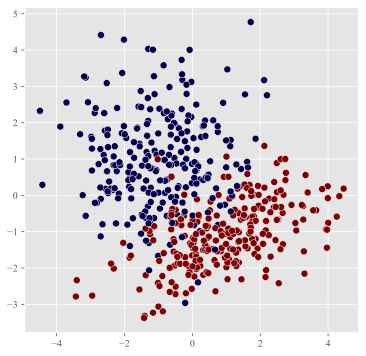

In [4]:
# сгенерируем данные
from sklearn import datasets
from sklearn import model_selection

X, y = datasets.make_classification(n_samples=500,
                                    n_features=5, n_informative=5,
                                    n_classes=2, n_redundant=0,
                                    n_clusters_per_class=1, random_state=13)


plt.figure(figsize=(6, 6))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)),
            c=y, cmap='seismic', edgecolors="white", s=50)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.3,
                                                                    random_state=1)

Случайный лес из 30 деревьев. Тестовая выборка. Метрика accuracy = 0.8933
Случайный лес из 30 деревьев. Тестовая выборка. Метрика f1_score = 0.8904
Случайный лес из 30 деревьев. Тестовая выборка. Метрика precision_recall = (0.9028, 0.8784)



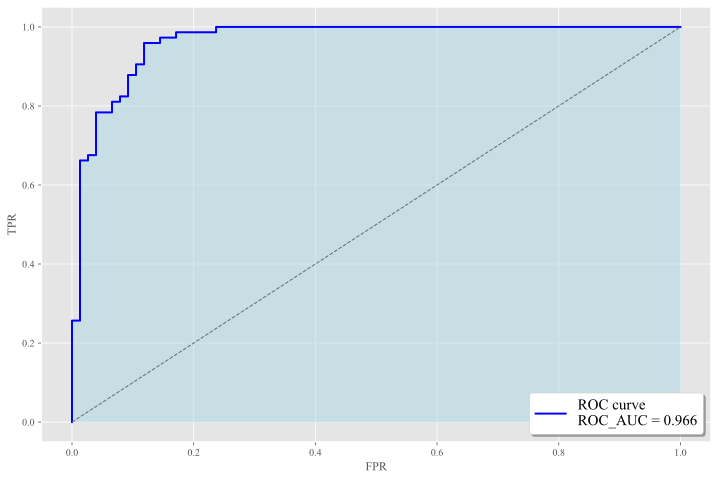

In [5]:
# проверка работы алгоритма случайного леса без использования РСА
rf_model = RFClassifier(n_trees=30, random_state=13, max_depth=6, min_leaf=1)
rf_model.fit(X_train, y_train)
y_pred, y_proba = rf_model.predict(X_test)
title = f'Случайный лес из 30 деревьев. Тестовая выборка'
get_full_report(y_test, y_pred, y_proba, title=title)
roc_auc(y_test, y_proba)

Случайный лес из 30 деревьев. Тестовая выборка. РСА - 2 компоненты. Метрика accuracy = 0.6267
Случайный лес из 30 деревьев. Тестовая выборка. РСА - 2 компоненты. Метрика f1_score = 0.541
Случайный лес из 30 деревьев. Тестовая выборка. РСА - 2 компоненты. Метрика precision_recall = (0.6875, 0.4459)



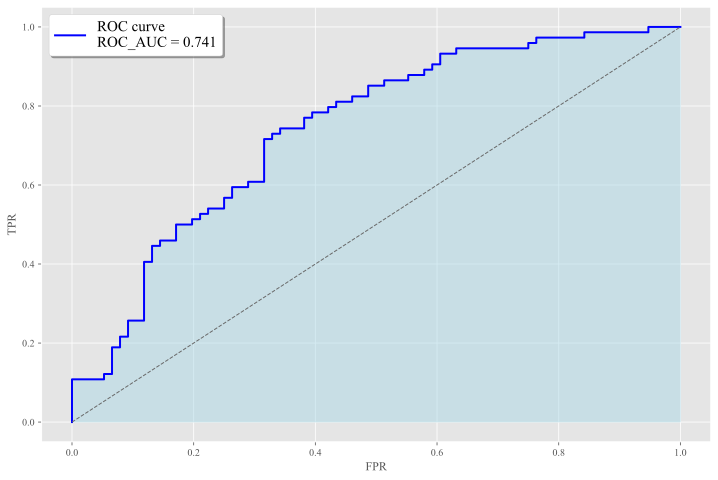

In [6]:
# проверка работы алгоритма случайного леса с использованием РСА. Оставляем 2 главные компоненты
downweighting = PCA(2)
downweighting.fit(X_train)
X_train_pca = downweighting.transform(X_train)
X_test_pca = downweighting.transform(X_test)

rf_model_pca = RFClassifier(n_trees=30, random_state=13, max_depth=4, min_leaf=1)
rf_model_pca.fit(X_train_pca, y_train)
y_pred_pca, y_proba_pca = rf_model_pca.predict(X_test_pca)
title = f'Случайный лес из 30 деревьев. Тестовая выборка. РСА - 2 компоненты'
get_full_report(y_test, y_pred_pca, y_proba_pca, title=title)
roc_auc(y_test, y_proba_pca)